<a href="https://colab.research.google.com/github/HarryWang0619/ECE397-QuantumComputing/blob/main/Haochen_Wang_Lab_7_Grover_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 397 QC

## Introduction to Quantum Computing – Spring 2022

Instructor – Professor Robert Niffenegger (rniffenegger@umass.edu ) Marcus 215B

Labs -  Engineering Lab 307

Time – MWF 12:20-1:10

Teaching Assistant – Ivan Williams ( inwilliams@umass.edu ) 

---

### Textbook
>Quantum Computation and Quantum Information , Authors:	Michael A. Nielsen, Isaac L. Chuang


###Quantum Computation resources:

•	Thomas Wong’s Textbook:
  * https://www.amazon.com/Introduction-Classical-Quantum-Computing-Thomas-dp-B09QP2MYYM/dp/B09QP2MYYM/
  * http://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e2p.pdf


•	IBM’s Qiskit Textbook - https://qiskit.org/textbook-beta 


#How to use this Notebook

1. Create a copy for you to edit and update the filename with your UMass username. 

2. Experiment! This notebook is just a starting point for you to explore. If you have ideas for things to try start by typing out the pseduo code first then see if you can find help to get the syntax and libraries to make it work. 

3. Teamwork. Working in teams will help everyone check their code and debug errors. Please work in groups of up to three people. You may all share code but please maintain your own copy of the notebook to turn in for credit.

4. Hand written paper notebook still required. This colab notebook is a supplement to a paper notebook and the textbooks listed above. To test out ideas, check mathematical relations and linear algebra proofs and to complete exercises you will need a real physical paper notebook to do your work. Please have one and a pen/pencil handy. 
Related: Be careful not to get bogged down in the code if it is not working. Reach out to your team, the TA or me to get assistance. 

5. Programming Resources: 
  *   https://colab.research.google.com/notebooks/basic_features_overview.ipynb
  *   https://www.dataquest.io/blog/jupyter-notebook-tutorial/
  *   https://www.youtube.com/watch?v=inN8seMm7UI 
  *   https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/qubit-dynamics.ipynb
  * FYI: Colab provides hardware acceleration with GPUs and TPUs if you go to 'Runtime>Change Runtime type'


#QuTiP
Install QuTiP using 'pip' within Colab. 
(Any library not native to Colab can be installed this way.)

In [170]:
try:
  import qutip
except ImportError:
  print('Install Qutip')
  !pip install --quiet qutip

#Qiskit

IBM's Quantum Information Software Kit

In [171]:
try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [172]:
try:
  import ibm_quantum_widgets
except ImportError:
  !pip install --quiet ibm-quantum-widgets

# Initialize and import

In [173]:
# Sometimes reseting is helpful short of restarting the whole kernel
# %reset


In [174]:
%matplotlib inline
from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
import math
import time


#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#QuTiP imports
import qutip as qt
from qutip import *


#Qisket imports
from qiskit import *
# from qiskit import QuantumCircuit, transpile, assemble, Aer , IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.aer import QasmSimulator


from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info.operators import Operator


from qiskit.providers.basicaer import BasicAer
from qiskit.providers.aer.noise import *

from qiskit.quantum_info import Statevector
'''
In Jupyter Notebooks we can display this nicely using Latex.
'''
from qiskit.visualization import array_to_latex


In [175]:
'''
Optional
Load your IBM Q account
'''

# from qiskit import IBMQ

# IBMQ.save_account('INSERT YOUR API TOKEN HERE', overwrite=True)

# provider = IBMQ.load_account()

# Configure simulation engine
backend = Aer.get_backend('qasm_simulator')

# Grover Search (Amplitude Amplification)

You have likely heard that one of the many advantages a quantum computer has over a classical computer is its superior speed searching databases. 
The Grover Search algorithm can search large datasets in an efficient way. 

To locate a specified item from a list of many items, a classical computer must examine each element until the solution is located. For a set of N items, this takes, on average, N/2 searches. 

A quantum computer using a Grover search can provide arbitrarily confident guesses for the location of the desired item depending on the number of times the algorithm is performed. Typically the average number of required searches is $\sqrt{N}$ , which has been proven to be the fastest speedup possible for this problem (Bennett, 1997).

Grover's algorithm can also serve as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called  **amplitude amplification**.

> reference: 
* https://qiskit.org/textbook/ch-algorithms/grover.html
* Thomas Wong's book - 7.6 Brute-Force Searching

Let's see how it works:

The first steps are to create a massive superposition state:

1. Create N qubit register
1. Apply Hadamard Gates to put every qubit in a perfect superposition state $|+X⟩ = \frac{|0⟩ + |1⟩}{\sqrt{2}}$

Then measure just to see what we have so far.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  from ipykernel import kernelapp as app


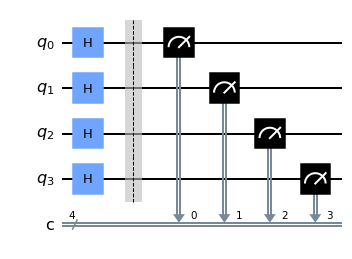

In [176]:
#Number of qubits
N = 4

#Blank register (zeros)
quantum_circuit = QuantumCircuit(N)

#Hadmards for each input state 
for i in range(N):
    quantum_circuit.h(i)

# Measurements
meas = QuantumCircuit(N, N)
meas.barrier(range(N))
meas.measure(range(N), range(N))
quantum_circuit = quantum_circuit + meas

#Draw
quantum_circuit.draw('mpl')

Applying Hadamard gates to each qubit creates the uniform superposition state |s⟩

Here is an image from the QisKit textbook to help represent the algorithm. 

The state |w⟩ represents the solution, and |s⟩ is the equal superposition state . |s'⟩ therefore is an arbitrary state that it is orthogonal to |w⟩, making it the state of all the incorrect states. 

The search will allow us to test all of these superposition states in |s⟩ **simultaneously** to see if they are the 'correct' answer |w⟩. However, this process is iterative and equivalent to rotating the vector closer to |w⟩ and farther from |s'⟩


![Grover](https://qiskit.org/textbook/ch-algorithms/images/grover_step1.jpg)

We can verify we have created an equal superposition state by simulating our circuit. 

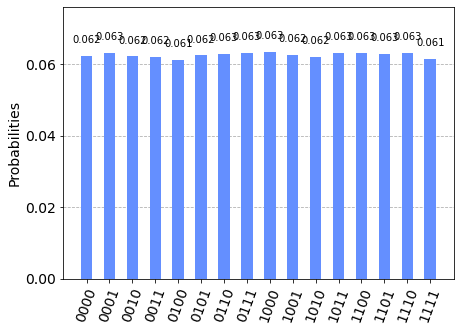

In [177]:
'''
Simulate algorithm so far
'''
# Configure simulation engine
backend = Aer.get_backend('qasm_simulator')

#Use MANY trails just to get a nicer equal superpostion
n_shots = 1024*100

job_sim = execute(quantum_circuit, backend, shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# Plot results
plot_histogram(counts)

State initilized $\checkmark$

All of the states have a roughly equal amplitude. We have no way to know which one is the correct solution and which is incorrect.

#Apply the Oracle

Now we can apply the "oracle". This is a gate which acts on all qubits and contains a piece of information which identifies the correct solution to the search. One of the exercises will show how you can construct this gate as a set of tests, checks, or logical clauses, using the rules of Sudoku as an example.

However, as a first trivial example we can modify an identity matrix by flipping a single entry negative to represent the correct solution. 

> *This seems like a very silly way to start a search (by specifying the answer) and indeed if you would like, please randomize the process and don't check until after the quantum version runs 😏.
Further, the main exercise of this lab will have you constuct a logical check oracle based on the rules of Sudoko.*

It is instructive to note that the encoded 'solution' could also represent the configuration of the permuted bits and not just an integer as we will use. 
It is also important to note that multiple configurations can be designated as solutions, which in this example would mean multiple integers. 


Step 2: We apply the oracle reflection  $U_f$  to the state  |s⟩ .

![Grover Step 2](https://qiskit.org/textbook/ch-algorithms/images/grover_step2.jpg)

After applying the oracle we have flipped the register's state about |s'⟩ in the 2 dimensional state space. This means the probability amplitude of |w⟩ is reflected about 0, while all other states are raised slightly in response.

To create this operation:

In [178]:
'''
Automatic arbitrary oracle construction to compiled gate
'''

# Number of qubits
N = 4

#Maximum encodable number
print('Max of' , N , 'qubit register =' , 2**N-1)

# Arbitrarily chosen solution of the Grover Search
solution = 12

binarystring = format(solution,"b")
print('Solution=',  int(binarystring,2))
print('Binary String of solution =' , binarystring)

'''
*** Create Oracle ***
Notice it is just an identity matrix with a single negative entry
'''
matrix = np.identity(2**N, complex)
matrix[solution, solution]*=-1


# Convert this matrix to a gate that we can add to the circuit
controls = QuantumRegister(N)
circuit = QuantumCircuit(controls)

gate = Operator(matrix)

circuit.unitary(gate, range(0, N))
Oracle = circuit.to_gate()
Oracle.name = 'Oracle'


Max of 4 qubit register = 15
Solution= 12
Binary String of solution = 1100


(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fa4970a1950>)

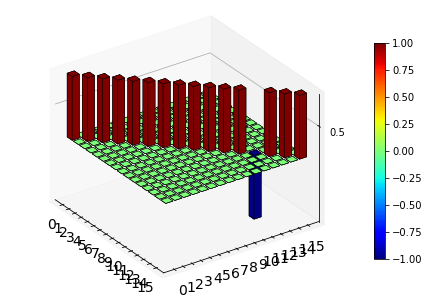

In [179]:
#Plot the Oracle matrix
matrix_histogram(matrix)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa496d4b850>)

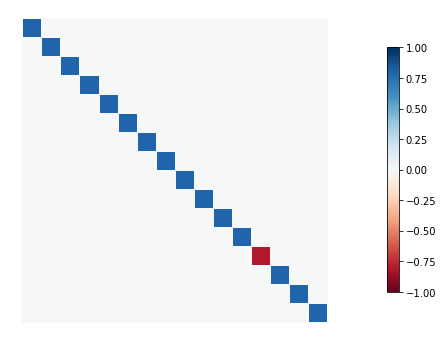

In [180]:
#Plot the Oracle matrix
hinton(matrix)

Apply oracle to the circuit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.


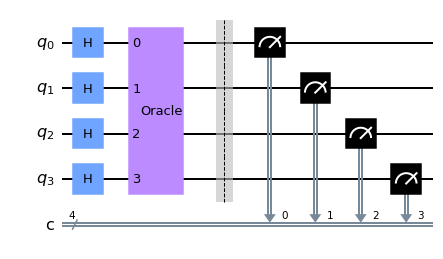

In [181]:
# Number of qubits
N = 4

#declare new circuit with N qubits
quantum_circuit = QuantumCircuit(N)

# Add Hadamard gates to each qubit
for i in range(N):
    quantum_circuit.h(i)

# Add the Oracle gate
quantum_circuit.append(Oracle, range(N))


# Measurements
meas = QuantumCircuit(N, N)
meas.barrier(range(N))
meas.measure(range(N), range(N))
quantum_circuit = quantum_circuit + meas

#Draw
quantum_circuit.draw('mpl')

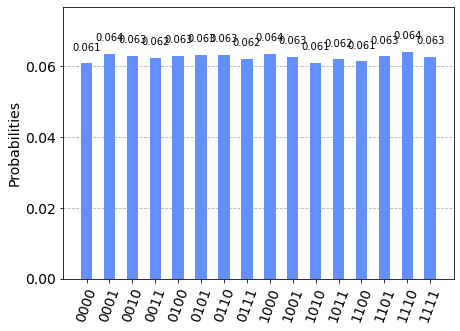

In [182]:
# Configure simulation engine
backend = Aer.get_backend('qasm_simulator')

#Use MANY trails just to get a nicer equal superpostion
n_shots = 1024*100

job_sim = execute(quantum_circuit, backend, shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# Plot results
plot_histogram(counts)

Statevector([ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
              0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
              0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,
              0.25+0.j],
            dims=(2, 2, 2, 2))


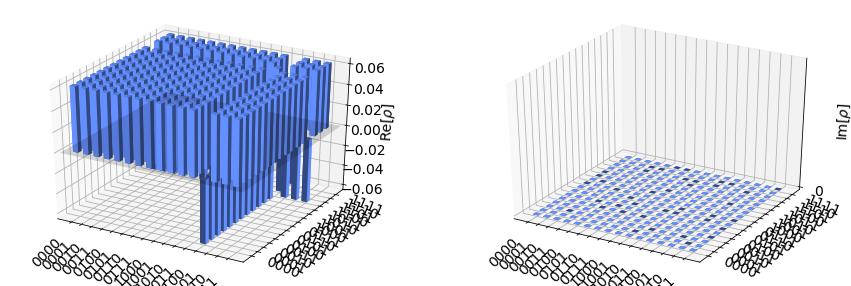

In [183]:
from qiskit.visualization import plot_state_city, plot_state_hinton

# Retrieve the statevector_simulator backend
state_backend = Aer.get_backend('statevector_simulator')

# Number of qubits
N = 4
quantum_circuit = QuantumCircuit(N)
for i in range(N):
    quantum_circuit.h(i)
# Add the Oracle gate
quantum_circuit.append(Oracle, range(N))

'''OMIT MEASUREMENTS TO PRESERVE STATEVECTOR'''


#Simulate
job_sim = execute(quantum_circuit, state_backend, shots=1024)
result_sim = job_sim.result()

# Get the statevector from result
statevector = result_sim.get_statevector(quantum_circuit)

print(statevector)

# https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.draw.html#qiskit.quantum_info.Statevector.draw

# plot_state_city(statevector)
statevector.draw('city')

In [184]:
statevector.draw('latex')

<IPython.core.display.Latex object>

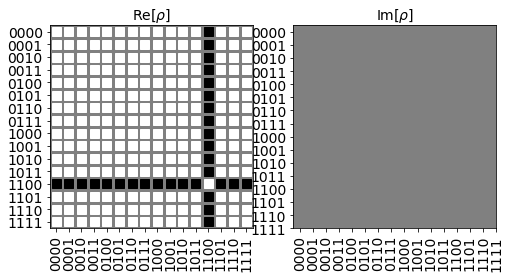

In [185]:
statevector.draw('hinton')

Nothing to see yet. We have only flipped the sign of the amplitude. When we measure the probabilty of that state we still get the same probability as when it was postive!

We need to find a way to increase the amplitude of the flipped state |w⟩ and decrease the amplitude of all the other states |s'⟩...

#Amplify by reflection about the 'average amplitude' state |s⟩ 

(aka apply Diffuser , Reflection $U_s$) 

To amplify the amplitudes of the correct quantum states we will now **reflect** the state about the uniform superposition state |s⟩ that was input into the Oracle. 

This reflection amplifies the amplitude of the solution state at the expense of lowering the amplitude of all the other states.

>Remember that the total propability is still 1, so the normalized total amplitudes must be conserved.  Therefore this has the effect of 'diffusing' the amplitude of the wrong states away and it is also referred to as the generalized diffuser.

You can see this pictorally below as the state vector is reflected about the  uniform superposition state |s⟩ , bringing it closer to the solution state |w⟩ and farther from the orthogonal 'wrong states' |s'⟩. (Note the total probability (the length of the full state vector) doesn't change, just it's angle.)

The amplitude vs N states on the right shows how the component of the full state vector that is the solution state |w⟩ (purple) is now amplified relative to all the other states (grey). 
While the oracle had flipped the sign of the correct state it had not yet amplified it. 


Apply an reflection ( $U_s$ ) about the uniform superposition state  $|s⟩ :  U_s =2|s⟩⟨s|−1 $


![Grover Step 3](https://qiskit.org/textbook/ch-algorithms/images/grover_step3.jpg)

With the application of the diffuser, the register is rotated about |s⟩. The result is that it more closely aligns with |w⟩. All probabilities have been drastically decreased except for that corresponding to the correct answer, which has been increased significantly!


---


## But how is this done?



While it is not immediately obvious how to reflect about the uniform superposition state we DO know how to reflect about the |000...0⟩ state. 
Or rather we know how to flip the sign of the |111..1⟩ state....

A multi-qubit-control-phase gate will flip the sign of the |111...1⟩ state but no others.

So we'll need two transformations to perform the reflection.


Therefore if we want to reflect about |s⟩ we naively: 
* Transform register back to original |000...0⟩ 
  * Flip register to |111..1⟩
    * Apply CCZ gate (multi-qubit-control-phase-gate, flipping only |111..1⟩)
  * Flip register to |000...0⟩
* Transform back from |000...0⟩ to |s⟩

'Naively' here emphasizes that once the Oracle has flipped the amplitude of the solution state this transformation is no longer a trivial operation as it would be without having first applied the oracle.

REMEMBER:

This is simliar to how we converted a Controlled Phase gate (Control Z gate) into a Controlled X Gate (Control Not gate) by first transforming to the phase basis. 

* Hadamard converts from Z basis to X basis 
  * Control Phase gate (rotating about Z)
* Hadamard back from X basis to Z basis


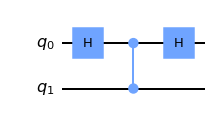

In [186]:
from qiskit.circuit.library import *
qc = QuantumCircuit(2)

# Hadamard Gate on target qubit
qc.h(0) 
# Control Phase gate
qc.cz(0,1)
# Hadamard Gate on target qubit
qc.h(0) 

# Draw the circuit
qc.draw('mpl')

> Note a very unusual notation. **No control or target was defined by the control phase gate.** This is because the phase is relative to BOTH qubits. Choosing one or the other would be just a global rotation to both. 

## Steps to create the amplitude amplification circuit:

1. Convert |s⟩ → |0⟩ by applying Hadamard gates to all qubits
   
   Remember |s⟩ is the uniform superposition state we started with after applying Hadamards to each qubit. So to get back from |s⟩ to |0⟩ again we just apply Hadmard gates once more. 

   HOWEVER, if a state had it's sign flipped by the Oracle it does not return to |0⟩.  Instead it is |1⟩! This is critical for the algorithm to work.

1. Apply a negative phase to anything except the |00...0⟩  state
  1. Flip all qubits from 0 to 1 by applying X gates (conversely 1 to 0)
  1. Apply multi-qubit controlled phase gate ( like a 'phase' Toffoli)
  
  >Flipping the sign of the |11...1⟩ state (which was just originally in the |00...0⟩ state)

  1. Flip all qubits back from |1⟩ to |0⟩ by applying X gates
1. Convert back from |00...0⟩ to superposition state |s⟩ 'basis' by applying Hadamard gates to all qubits.

Let's see how to create this diffuser operation:

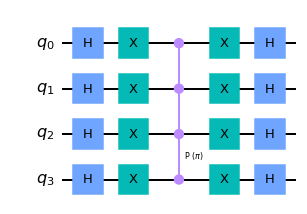

In [187]:
qc = QuantumCircuit(N)

# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(N):
    qc.h(qubit)

# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(N):
    qc.x(qubit)

''' 
Multi-controlled-Z gate
'''
qc.append(MCPhaseGate(lam=pi , num_ctrl_qubits=N-1),[0,1,2,3])

# Apply transformation |11..1> -> |00..0>
for qubit in range(N):
    qc.x(qubit)

# Apply transformation |00..0> -> |s>
for qubit in range(N):
    qc.h(qubit)

qc.draw('mpl')


In [188]:
'''
Compile the diffuser circuit into a single for convienence
(We call it U_s to refer to it's reflection about the original |s> state)
'''
U_s = qc.to_gate()
U_s.name = "U$_s$"

## Decomposing a multi-qubit Controlled phase gate

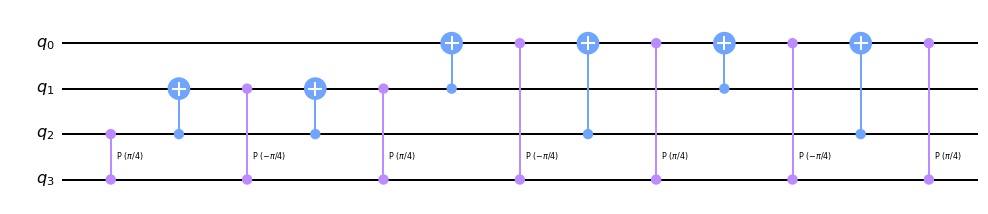

In [189]:
N=4

qc_MCPHASEGATE = QuantumCircuit(N)

''' 
Multi-controlled-Z gate
'''
qc_MCPHASEGATE.append(MCPhaseGate(lam=pi , num_ctrl_qubits=N-1),list(range(0,N)))

decomposed_circ = qc_MCPHASEGATE.decompose()
decomposed_circ.draw('mpl')

In [190]:
'''
Calculate the depth of the quantum circuit
'''
decomposed_circ.depth()

13

We see that much like the 'Controlled-Control-X Gate' (CCX, Toffoli Gate), executing the Controlled-Control-Phase gate on actual qubits requires many two qubit operations. 

Two qubit Control Phase gates & Two qubit CNOT gates

13 total gates for just a 4 qubit register

> Note the massively entangled state created from these operations!

#Putting the Reflection together with the Oracle

Apply reflection gate to the rest of our circuit to amplify the solution.

First the statevector (before measuring)

Statevector([-0.1875-6.50593612e-17j, -0.1875-8.80214887e-17j,
             -0.1875-8.80214887e-17j, -0.1875-1.10983616e-16j,
             -0.1875-1.18637659e-16j, -0.1875-1.10983616e-16j,
             -0.1875-1.10983616e-16j, -0.1875-1.33945744e-16j,
             -0.1875-1.18637659e-16j, -0.1875-1.10983616e-16j,
             -0.1875-1.10983616e-16j, -0.1875-1.33945744e-16j,
             -0.6875-3.55912976e-16j, -0.1875-1.64561914e-16j,
             -0.1875-1.64561914e-16j, -0.1875-1.56907871e-16j],
            dims=(2, 2, 2, 2))


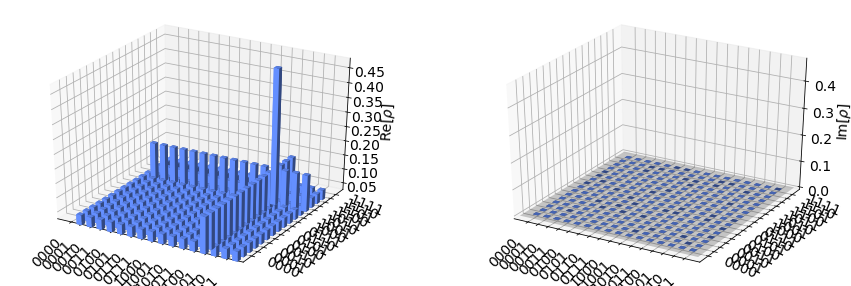

In [191]:
from qiskit.visualization import plot_state_city, plot_state_hinton

# Retrieve the statevector_simulator backend
state_backend = Aer.get_backend('statevector_simulator')

# Number of qubits
N = 4
quantum_circuit = QuantumCircuit(N)
for i in range(N):
    quantum_circuit.h(i)
# Add the Oracle gate
quantum_circuit.append(Oracle, range(N))


# Add the Diffuser (U_s)
quantum_circuit.append(U_s, range(N))

'''OMIT MEASUREMENTS TO PRESERVE STATEVECTOR'''


#Simulate
job_sim = execute(quantum_circuit, state_backend, shots=1024)
result_sim = job_sim.result()

# Get the statevector from result
statevector = result_sim.get_statevector(quantum_circuit)

print(statevector)

# https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.draw.html#qiskit.quantum_info.Statevector.draw

# plot_state_city(statevector)
statevector.draw('city')

Adding measurements to get the probabilities:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.


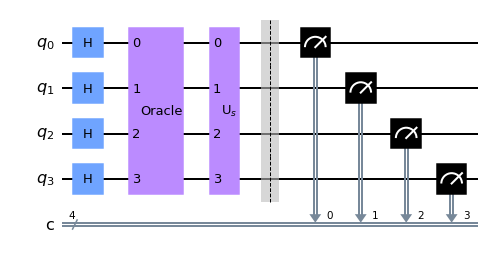

In [192]:
# Number of qubits
N = 4

#declare new circuit with N qubits
quantum_circuit = QuantumCircuit(N)

# Add Hadamard gates to each qubit
for i in range(N):
    quantum_circuit.h(i)

# Add the Oracle
quantum_circuit.append(Oracle, range(N))

# Add the Diffuser (U_s)
quantum_circuit.append(U_s, range(N))

# Measurements
meas = QuantumCircuit(N, N)
meas.barrier(range(N))
meas.measure(range(N), range(N))
quantum_circuit = quantum_circuit + meas

#Draw circuit
quantum_circuit.draw('mpl')


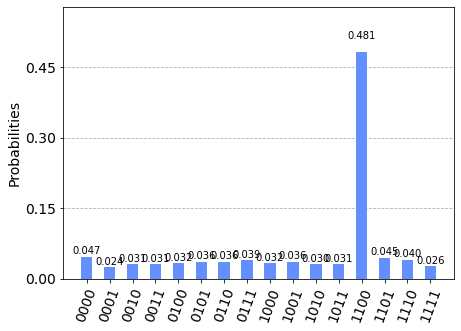

In [193]:
# Configure simulation engine
backend = Aer.get_backend('qasm_simulator')

# Simulate algorithm
job_sim = execute(quantum_circuit, backend, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# Plot results
plot_histogram(counts)

Wow! One iteration and already we really see a huge effect! We already have a nearly 50% chance of getting the correct solution each shot. Not bad. 


However, we can actually iterate one more time to fully rotate closer to 100%!

# Iterate $\sqrt{N}$ Times

The Oracle and Diffuser make up the Grover Operator. 

Typically, we must execute the Grover Operator $\sqrt{N}$ times, which means larger searches do indeed take more time, even on a quantum computer. Regardless a quadratic speedup is still observed! 

For 4 qubits we'll iterate one more time (two total).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.


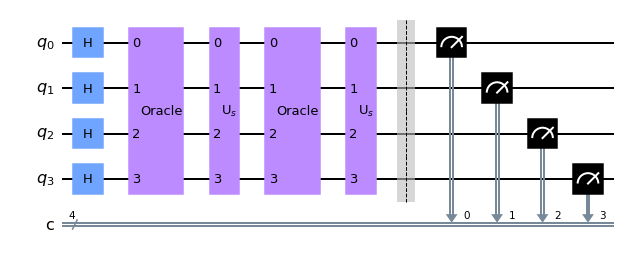

In [194]:
# Number of qubits
N = 4

#declare new circuit with N qubits
quantum_circuit = QuantumCircuit(N)

# Add Hadamard gates to each qubit
for i in range(N):
    quantum_circuit.h(i)

# Apply Oracle and Diffuser (Grover operator) sqrt(N) times
for i in range(int(sqrt(N))):
    quantum_circuit.append(Oracle, range(N))
    quantum_circuit.append(U_s, range(N))
            
# Conclude by making measurements
meas = QuantumCircuit(N, N)
meas.barrier(range(N))
meas.measure(range(N), range(N))
quantum_circuit = quantum_circuit + meas

#Draw
quantum_circuit.draw('mpl')

# Execute the circuit!

Now we can execute the circuit and meaure many trials or 'shots' and hopefully see that the correct answer is measured far more often than any other. This step finally collapses the wavefunction of our registers and effectively converts it to a classical register with a value corresponding to the correct search index.

Simulation runtime: 0.121


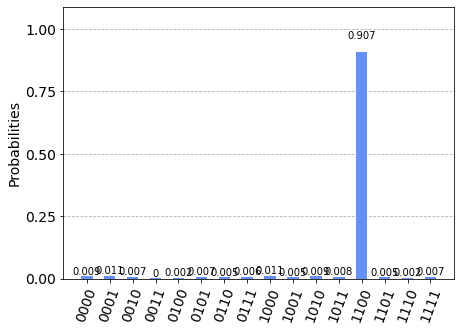

In [195]:
# Record the time it takes to simulate
start = time.time()

# Simulate algorithm
n_shots = 1024
job_sim = execute(quantum_circuit, backend, shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# How long did this take?
elapsed = round(time.time() - start,3)
print("Simulation runtime: " + str(elapsed))

# Plot results
plot_histogram(counts)

Wow, we see that two iterations have really isolated the result and any subsequent iterations are not necessary.

In [196]:
#Get the most likely measured result from the counts
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)
print( 'Most frequent measured integer = ' ,int(answer,2))

#What was the desired solution again?
print( '\nDesired solution = ' , solution)

print('\nTotal counts of most frequent result = ' , counts[answer] )
print('Total shots = ' , n_shots)
print('Probability of getting answer = ' , round(counts[answer]/n_shots *100,2) ,'%')


Most frequent measured bit string =  1100
Most frequent measured integer =  12

Desired solution =  12

Total counts of most frequent result =  929
Total shots =  1024
Probability of getting answer =  90.72 %


>90% ✅ Not bad!

# How well does this scale ***classically***?

To see how well this scales on the classical simulator, let's run the above code for several values of N and time how long it takes. 

In [197]:
min_bits = 3
max_bits = 11
elapsed_times = []

desired_solution = 3

for n in range(min_bits, max_bits+1):

    ## Create register
    quantum_circuit = QuantumCircuit(n)

    ## Create superposition
    for i in range(n):
        quantum_circuit.h(i)
    
    #Create Oracle Gate
    controls = QuantumRegister(n)
    circuit = QuantumCircuit(controls)
    matrix = np.identity(2**n, complex)
    matrix[desired_solution, desired_solution]*=-1
    gate = Operator(matrix)
    circuit.unitary(gate, range(0, n))
    Oracle_N = circuit.to_gate()
    Oracle_N.name = 'Oracle_N'
    

    '''
    Create Diffuser Gate
    '''
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)

    ''' 
    Multi-controlled-Z gate
    ------------------
    Sandwiching Hadmard gates around the target qubit 
    --> Converts a CCX gate to a CCZ gate
    (This is easier to script for variable qubit numbers)
    '''    
    #Hadamard to convert CNOT gate to Cphase gate
    qc.h(n-1)
    
    #CCNOT gate (Toffili)
    qc.mct(list(range(n-1)), n-1)
    
    #Hadamard to convert back after application of CCX
    qc.h(n-1)

    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)

    #Compile into single 'gate'
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    # Apply sqrt(n) Oracle and Diffuser Gates to register
    for i in range(int(np.sqrt(n))):
        quantum_circuit.append(Oracle_N, range(n))
        quantum_circuit.append(U_s, range(n))
    
    #Add Measurements
    meas = QuantumCircuit(n, n)
    meas.barrier(range(n))
    meas.measure(range(n), range(n))
    quantum_circuit = quantum_circuit + meas

    #Measure simulation time
    start = time.time()

    #Simulate Circuit
    n_shots = 1024
    job_sim = execute(quantum_circuit, backend, shots=n_shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(quantum_circuit)
    sim_time = round(time.time() - start,3)
    elapsed_times.append(sim_time)
    print("SOLVED: n = " + str(n) + " qubits in " , sim_time, 'seconds')



SOLVED: n = 3 qubits in  0.057 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.


SOLVED: n = 4 qubits in  0.125 seconds
SOLVED: n = 5 qubits in  0.163 seconds
SOLVED: n = 6 qubits in  0.189 seconds
SOLVED: n = 7 qubits in  0.221 seconds
SOLVED: n = 8 qubits in  0.301 seconds
SOLVED: n = 9 qubits in  0.775 seconds
SOLVED: n = 10 qubits in  3.33 seconds
SOLVED: n = 11 qubits in  23.141 seconds


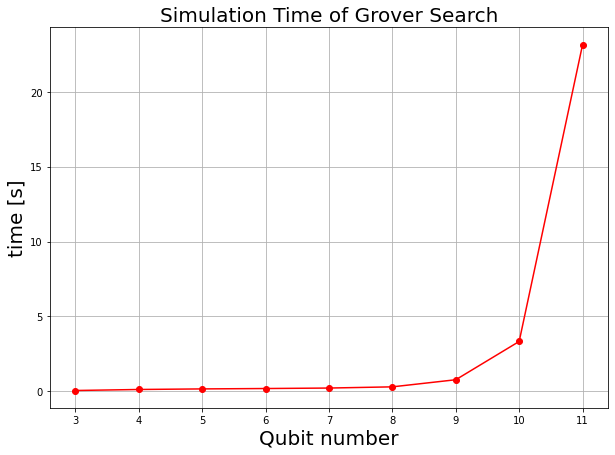

In [198]:
'''
Plot simulation time vs. Qubit number
'''
figsize = 10
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()

plt.plot(range(min_bits, max_bits+1), elapsed_times , 'o-r')

fs=20 #fontsize
plt.title('Simulation Time of Grover Search', fontsize=fs)
ax.set_ylabel(r'time [s]', fontsize=fs);
ax.set_xlabel(r'Qubit number', fontsize=fs);
plt.grid()


## Exponential Scaling Classically
The time to simulate Grover's Search increases **exponentially** on a classical computer. 

This is due to the fact that the operator matrices **double** in size every time we increase the number of qubits in the simulation. 

As a result we cannot rely on classical computers to perform this algorithm!

Quantum solutions to Grover's search show a quadratic speedup compared to classical solutions and actual quantum computers would be needed to show a speedup (on very large problems)...

---

Plotting the results of the last simulation:

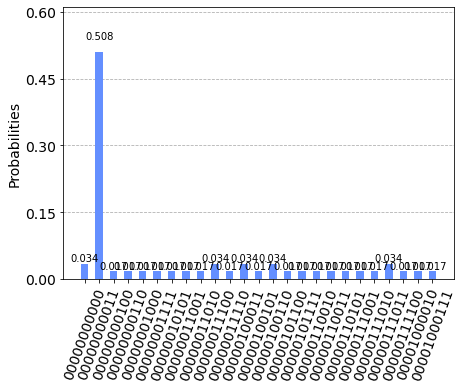

In [199]:
'''
Plot results
1. Sort results
2. Plot subset so it fits on figure
'''
#Sort by number of counts
sorted_counts_value = {k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])}

#Sort by bit string
sorted_counts_key = {k: counts[k] for k in sorted(counts.keys())}

#Just plot a subset (NOTE: Amplitudes overestimated due to many truncated states)
first_n_results = 25
# plot_histogram(dict(list(sorted_counts_value.items())[:first_n_results])) # Plot results (slow with many qubits)
plot_histogram(dict(list(sorted_counts_key.items())[:first_n_results])) # Plot results (slow with many qubits)


NOTE: Absolute probabilities in the above histogram are **WRONG** due to truncating the set. Probabilities would be much lower if normalized using ALL states.

Use the 'most_frequent()' method to get what that result is:

In [200]:
#Get the most likely measured result from the counts
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)
print( 'Most frequent measured integer = ' ,int(answer,2))

#What was the desired solution again?
print( '\nDesired solution = ' , desired_solution)

print('\nTotal counts of most frequent result = ' , counts[answer] )
print('Total shots = ' , n_shots)
print('Probability of getting answer = ' , round(counts[answer]/n_shots *100,2) ,'%')


Most frequent measured bit string =  00000000011
Most frequent measured integer =  3

Desired solution =  3

Total counts of most frequent result =  30
Total shots =  1024
Probability of getting answer =  2.93 %


Now we see that the correct answer has only a 2% chance of being measured. Still, with enough shots this is more likely than all of the other states and enough to determine the solution.

#Conclusion

Now that we have seen the essence of the Grover search we can move beyond the trivial Oracle we setup for the example. The main utility of a Grover search is when an Oracle is constructed that allows you to ask a question. This question can be a logical check. If qubit 1 then qubit 2 etc etc. 

To see how this is created the main exercise for this lab will be following the Qiskit tutorial on a 2x2 Binary Sudoku puzzle.

https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-

This is a very nice example in that it only requires encoding the Sudoku board in single qubits (binary encoding) and the logical checks allow multiple solutions. This is very interesting too. Multiple solutions can be tried simultaneously using Grover search and multiple solutions can be found.

That is, the state |w⟩ we are looking for is not necessarily a single qubit configuration, it could be many.

The 'Queens problem' (a chess problem) allows a similar encoding and a similar problem type but for larger arrays. Again multiple solutions (configurations) of queens on the chessboard can be checked with an appropriate oracle.



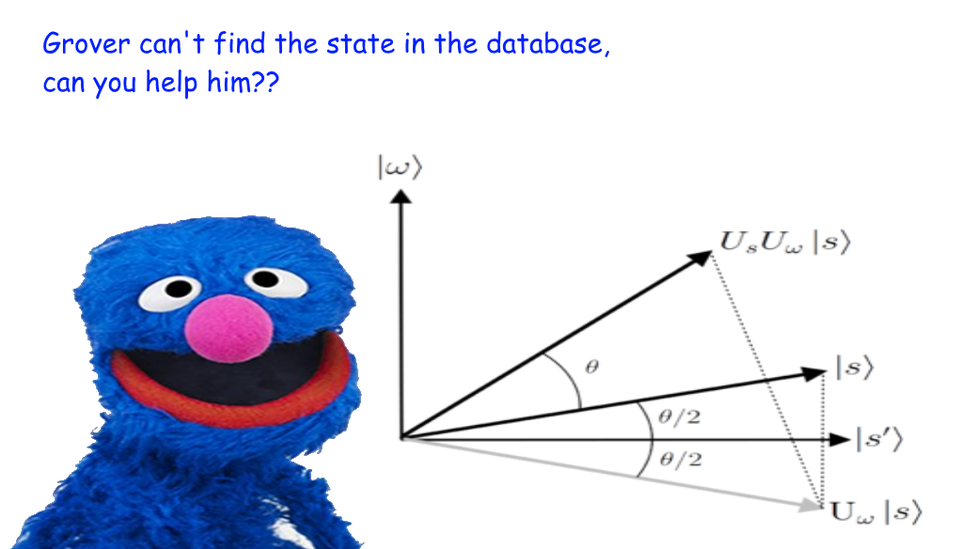

# Further reading:

IBM Qiskit tutorial 
* https://qiskit.org/textbook/ch-algorithms/grover.html#3qubits 

Amplitude amplification is also in Thomas Wong's textbook

* http://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e2p.pdf

Ion trap Experiment of 3 qubit Grover search
* 'Complete 3-Qubit Grover Search on a Programmable Quantum Computer' -  https://arxiv.org/abs/1703.10535



# Exercises


  1. Decompose the Multi-control-Phase gate for 5 qubits. How many 2 qubit gates are needed? Plot the number of two qubit gates vs qubits in the register up to 10 qubits. How does it scale? 

  1. Add an additional solution to the 4 qubit Grover search from the lab so there are two possible solutions. Show the result. What is the final state? Is it entangled?

  1. Recreate the Sudoku circuit for a 2x2 binary puzzle following this tutorial: 
  
  https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-

  1. In the Sudoku example, what is the Oracle? Plot the Oracle circuit and plot the Oracle Matrix.




### Exercise 1

Decompose the Multi-control-Phase gate for 5 qubits. How many 2 qubit gates are needed? Plot the number of two qubit gates vs qubits in the register up to 10 qubits. How does it scale?



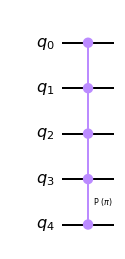

In [201]:
'''
Exercise 1
'''
N=5
qc = QuantumCircuit(N)
''' 
Multi-controlled-Z gate
'''
qc.append(MCPhaseGate(lam=pi , num_ctrl_qubits=N-1),range(N))

qc.draw('mpl')

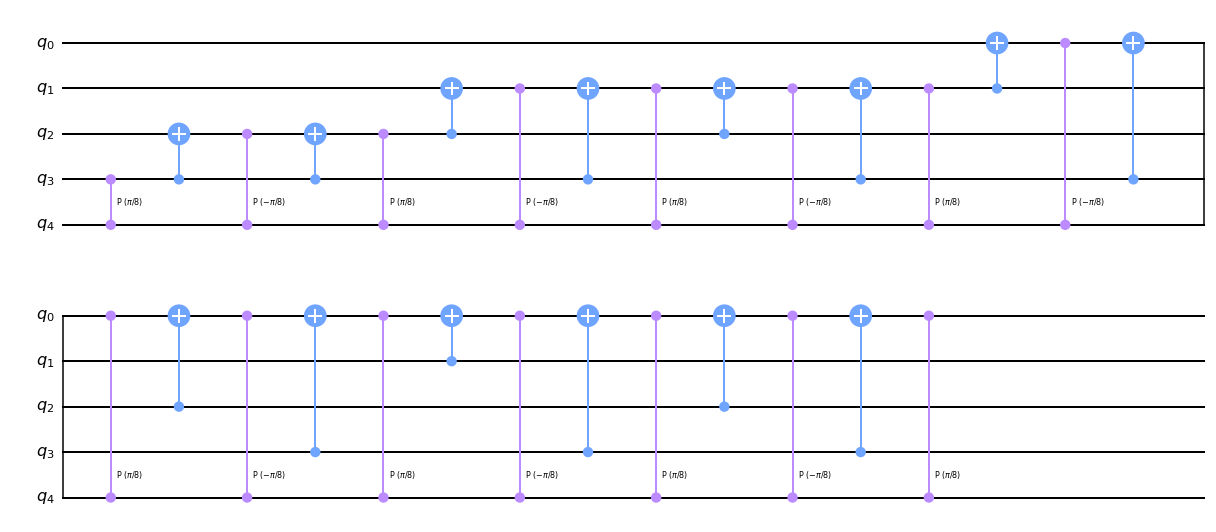

In [202]:
halfdecomposed = qc.decompose()
halfdecomposed.draw('mpl')

In [203]:
halfdecomposed.depth()

29

##### E1 ANSWER:

This is for all 2-qubit gate, the CX and CP.

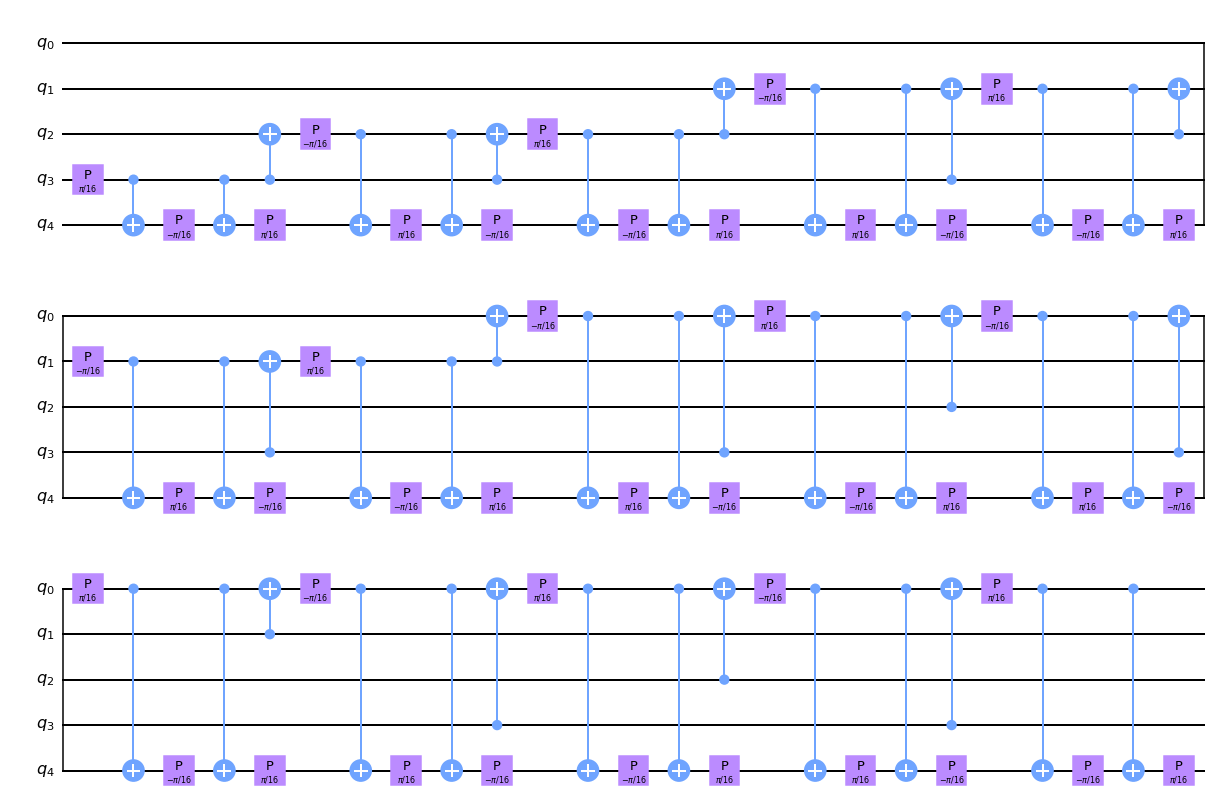

In [204]:
fulldecomposed = halfdecomposed.decompose()
fulldecomposed.draw('mpl')

In [205]:
from qiskit.converters import circuit_to_dag
transpile_circuit = transpile(fulldecomposed, backend)
dag_circuit = circuit_to_dag(transpile_circuit)
print(dag_circuit.count_ops_longest_path())
print(dag_circuit.count_ops_longest_path()['cx'])

{'p': 31, 'cx': 44}
44


This is for fully decomposed circuit, decomposed every other 2-qubit gates to CX/CNOT.

In [206]:
cnotlist = []
twoqubitlist = []
n = 5
while n <= 10:
  qc = QuantumCircuit(n)
  qc.append(MCPhaseGate(lam=pi , num_ctrl_qubits=n-1),range(n))

  halfdecomposed = qc.decompose()
  fulldecomposed = halfdecomposed.decompose()

  transpile_circuit = transpile(fulldecomposed, backend)
  dag_circuit = circuit_to_dag(transpile_circuit)

  twoqubitlist.append(halfdecomposed.depth())
  cnotlist.append(dag_circuit.count_ops_longest_path()['cx'])

  n+=1


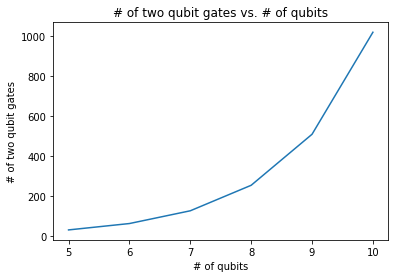

In [207]:
plt.plot(range(5,11),twoqubitlist)
plt.title("# of two qubit gates vs. # of qubits")
plt.xlabel('# of qubits')
plt.ylabel('# of two qubit gates')
plt.show()

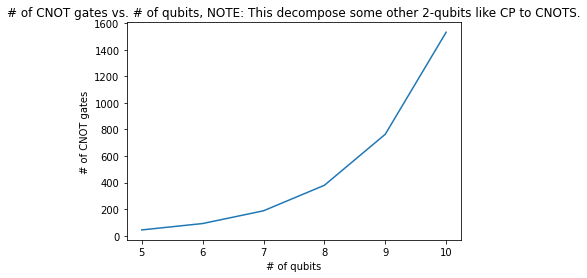

In [208]:
plt.plot(range(5,11),cnotlist)
plt.title("# of CNOT gates vs. # of qubits, NOTE: This decompose some other 2-qubits like CP to CNOTS.")
plt.xlabel('# of qubits')
plt.ylabel('# of CNOT gates')
plt.show()

### Exercise 2

Add an additional solution to the 4 qubit Grover search from the lab so there are two possible solutions. Show the result. What is the final state? Is it entangled?

In [209]:
'''
Exercise 2
'''
# Number of qubits
N = 4

#Maximum encodable number
print('Max of' , N , 'qubit register =' , 2**N-1)

# Arbitrarily chosen solution of the Grover Search
solution1 = 10
solution2 = 12

binarystring1 = format(solution1,"b")
print('Solution1=',  int(binarystring1,2))
print('Binary String of solution =' , binarystring1)
binarystring2 = format(solution2,"b")
print('Solution2=',  int(binarystring2,2))
print('Binary String of solution =' , binarystring2)


'''
*** Create Oracle ***
Notice it is just an identity matrix with a single negative entry
'''
matrix = np.identity(2**N, complex)
matrix[solution1, solution1]*=-1
matrix[solution2, solution2]*=-1

# Convert this matrix to a gate that we can add to the circuit
controls = QuantumRegister(N)
circuit = QuantumCircuit(controls)

gate = Operator(matrix)

circuit.unitary(gate, range(0, N))
Oracle = circuit.to_gate()
Oracle.name = 'Oracle'


Max of 4 qubit register = 15
Solution1= 10
Binary String of solution = 1010
Solution2= 12
Binary String of solution = 1100


(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fa49712fa90>)

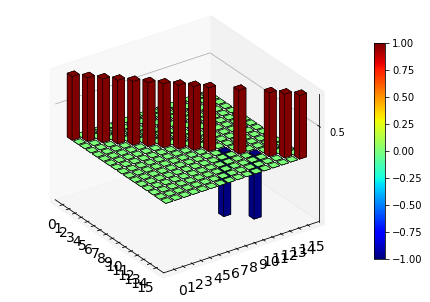

In [210]:
#Plot the Oracle matrix
matrix_histogram(matrix)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa49410d710>)

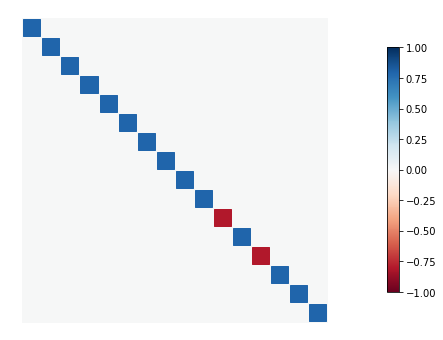

In [211]:
#Plot the Oracle matrix
hinton(matrix)

In [212]:
N = 4
qc = QuantumCircuit(N)

# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(N):
    qc.h(qubit)

# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(N):
    qc.x(qubit)

''' 
Multi-controlled-Z gate
'''
qc.append(MCPhaseGate(lam=pi , num_ctrl_qubits=N-1),[0,1,2,3])

# Apply transformation |11..1> -> |00..0>
for qubit in range(N):
    qc.x(qubit)

# Apply transformation |00..0> -> |s>
for qubit in range(N):
    qc.h(qubit)

'''
Compile the diffuser circuit into a single for convienence
(We call it U_s to refer to it's reflection about the original |s> state)
'''
U_s = qc.to_gate()
U_s.name = "U$_s$"

Statevector([-0.125-3.82702125e-17j, -0.125-5.35782975e-17j,
             -0.125-8.41944674e-17j, -0.125-6.88863825e-17j,
             -0.125-8.41944674e-17j, -0.125-6.88863825e-17j,
             -0.125-6.88863825e-17j, -0.125-8.41944674e-17j,
             -0.125-1.14810637e-16j, -0.125-6.88863825e-17j,
             -0.625-3.13815742e-16j, -0.125-1.14810637e-16j,
             -0.625-3.13815742e-16j, -0.125-1.14810637e-16j,
             -0.125-1.45426807e-16j, -0.125-9.95025524e-17j],
            dims=(2, 2, 2, 2))


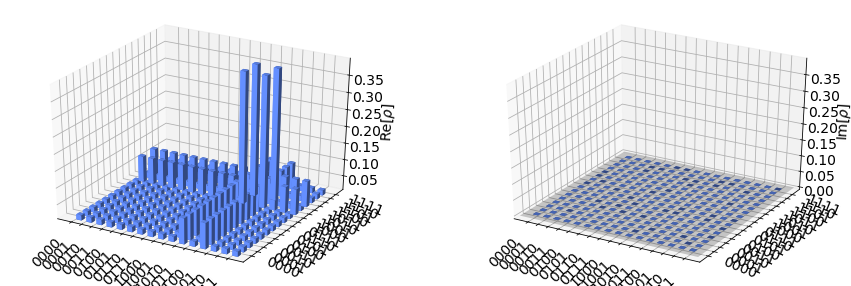

In [213]:
from qiskit.visualization import plot_state_city, plot_state_hinton

# Retrieve the statevector_simulator backend
state_backend = Aer.get_backend('statevector_simulator')

# Number of qubits
N = 4
quantum_circuit = QuantumCircuit(N)
for i in range(N):
    quantum_circuit.h(i)
# Add the Oracle gate
quantum_circuit.append(Oracle, range(N))


# Add the Diffuser (U_s)

quantum_circuit.append(U_s, range(N))

'''OMIT MEASUREMENTS TO PRESERVE STATEVECTOR'''


#Simulate
job_sim = execute(quantum_circuit, state_backend, shots=1024)
result_sim = job_sim.result()

# Get the statevector from result
statevector = result_sim.get_statevector(quantum_circuit)

print(statevector)

# https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.draw.html#qiskit.quantum_info.Statevector.draw

# plot_state_city(statevector)
statevector.draw('city')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.


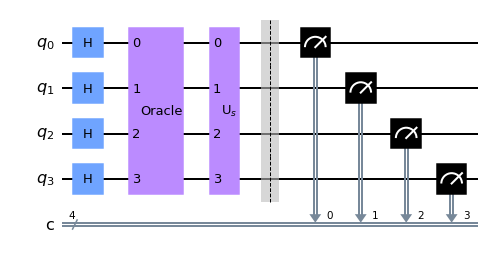

In [214]:
# Number of qubits
N = 4

#declare new circuit with N qubits
quantum_circuit = QuantumCircuit(N)

# Add Hadamard gates to each qubit
for i in range(N):
    quantum_circuit.h(i)

# Add the Oracle
quantum_circuit.append(Oracle, range(N))

# Add the Diffuser (U_s)
quantum_circuit.append(U_s, range(N))

# Measurements
meas = QuantumCircuit(N, N)
meas.barrier(range(N))
meas.measure(range(N), range(N))
quantum_circuit = quantum_circuit + meas

#Draw circuit
quantum_circuit.draw('mpl')


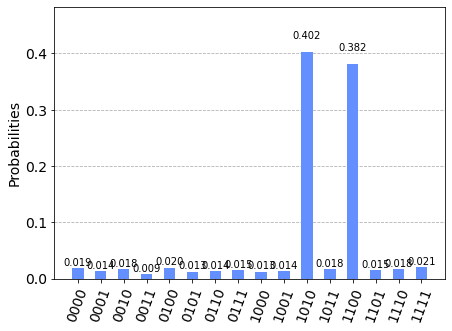

In [215]:
# Configure simulation engine
backend = Aer.get_backend('qasm_simulator')

# Simulate algorithm
job_sim = execute(quantum_circuit, backend, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# Plot results
plot_histogram(counts)

##### E2 ANSWER: 

Now with one iteration, this is already pretty good.

recall the 2 solutions we set in oracle:


In [216]:
binarystring1 = format(solution1,"b")
print('Solution1=',  int(binarystring1,2))
print('Binary String of solution =' , binarystring1)
binarystring2 = format(solution2,"b")
print('Solution2=',  int(binarystring2,2))
print('Binary String of solution =' , binarystring2)

Solution1= 10
Binary String of solution = 1010
Solution2= 12
Binary String of solution = 1100


Yes, we Have the same answer from the plot. 

Now, iterate it  $ \sqrt{N} $ times

(With multiple solutions, $ \sqrt{N/M} $ rotations would be suffice)
($ \sqrt{4/2}  = 1.41$, round up to $ 2 $ or maybe we can just do one iteration.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.


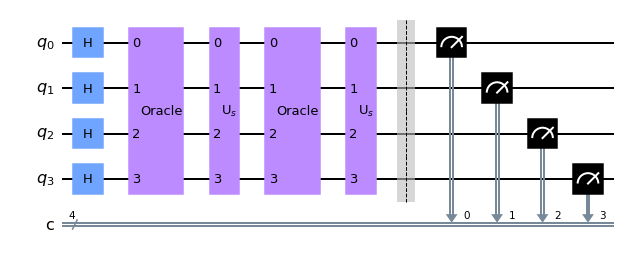

In [217]:
# Number of qubits
N = 4

#declare new circuit with N qubits
quantum_circuit = QuantumCircuit(N)

# Add Hadamard gates to each qubit
for i in range(N):
    quantum_circuit.h(i)

# Apply Oracle and Diffuser (Grover operator) sqrt(N) times
for i in range(int(np.sqrt(N))):
    quantum_circuit.append(Oracle, range(N))
    quantum_circuit.append(U_s, range(N))
            
# Conclude by making measurements
meas = QuantumCircuit(N, N)
meas.barrier(range(N))
meas.measure(range(N), range(N))
quantum_circuit = quantum_circuit + meas

#Draw
quantum_circuit.draw('mpl')

Simulation runtime: 0.116


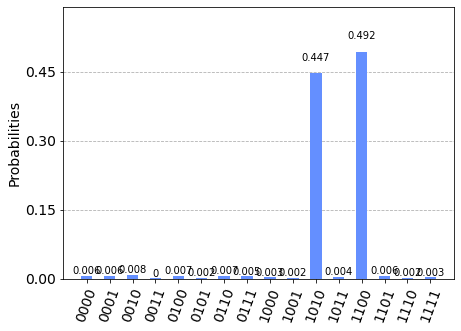

In [218]:
# Record the time it takes to simulate
start = time.time()

# Simulate algorithm
n_shots = 1024
job_sim = execute(quantum_circuit, backend, shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# How long did this take?
elapsed = round(time.time() - start,3)
print("Simulation runtime: " + str(elapsed))

# Plot results
plot_histogram(counts)

Even more accurate.

### Exercise 3

Recreate the Sudoku circuit for a 2x2 binary puzzle following this tutorial:

https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-

In [219]:
'''
Exercise 3
'''


'\nExercise 3\n'

In [220]:
clause_list = [[0,1],[0,2],[1,3],[2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

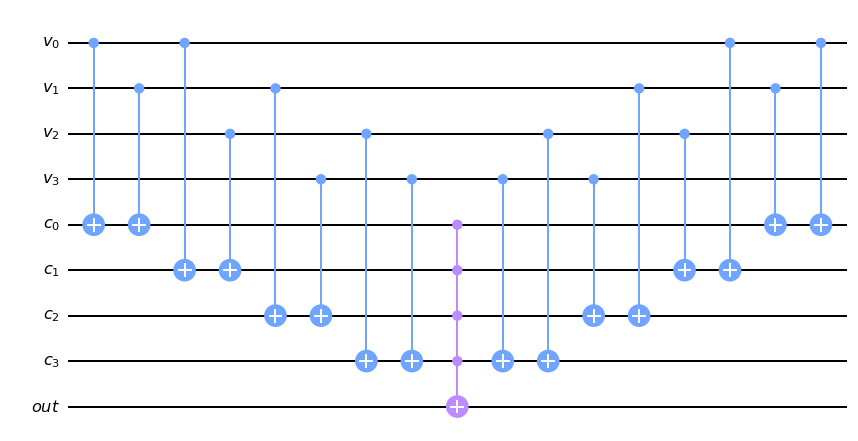

In [221]:
'''
The Sudoku Oracle, using the clause above, from IBM textbook. 
'''
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
# cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)
# qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0

    for clause in reversed(clause_list):
      i -= 1
      XOR(qc, clause[1], clause[0], clause_qubits[i])

sudoku_oracle(qc, clause_list, clause_qubits)

Sudoku_Oracle = qc.to_gate()
Sudoku_Oracle.name = "U$_\omega$"
qc.draw('mpl')

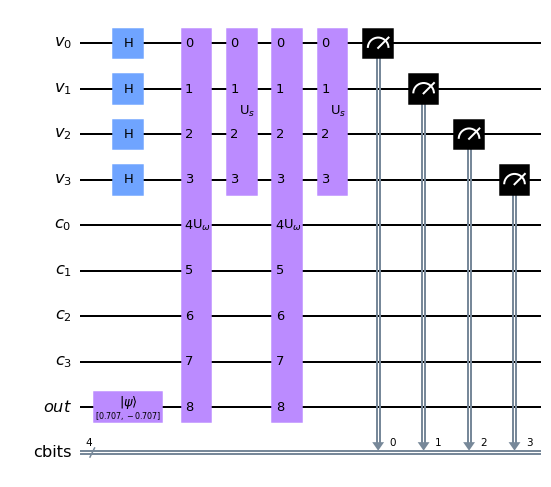

In [222]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
qc.initialize([1, -1]/np.sqrt(2), output_qubit)
for i in range(4):
    qc.h(i)
for i in range(2):
  qc.append(Sudoku_Oracle, range(9))
  qc.append(U_s,range(4))
qc.measure(var_qubits, cbits)
qc.draw('mpl')

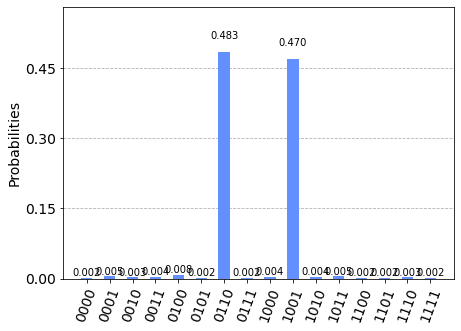

In [223]:
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

So, for the 2*2 binary sudoku, the two answer for
$ V_0, V_1, V_2, V_3$ are $0,1,1,0 $ or $1,0,0,1$, which match the answer. 

### Exercise 4

In the Sudoku example, what is the Oracle? Plot the Oracle circuit and plot the Oracle Matrix.

In [224]:
'''
Exercise 4
'''
clause_list = [[0,1],[0,2],[1,3],[2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

'\nExercise 4\n'

##### E4 ANSWER:

From the 2*2 Sudoku table 

v0 ≠ v1

v0 ≠ v2

v3 ≠ v1

v3 ≠ v2

------

So when v0 = v1, v0 = v2, v3 = v1, v3 = v2, the f(x) is 0; else, it's 1.

SO that's XOR, CNOT(CX). 

In the text, they use extra 4 clause qubit and an output qubit to verify the clause.

This is the Oracle for 2*2 binary sudoku


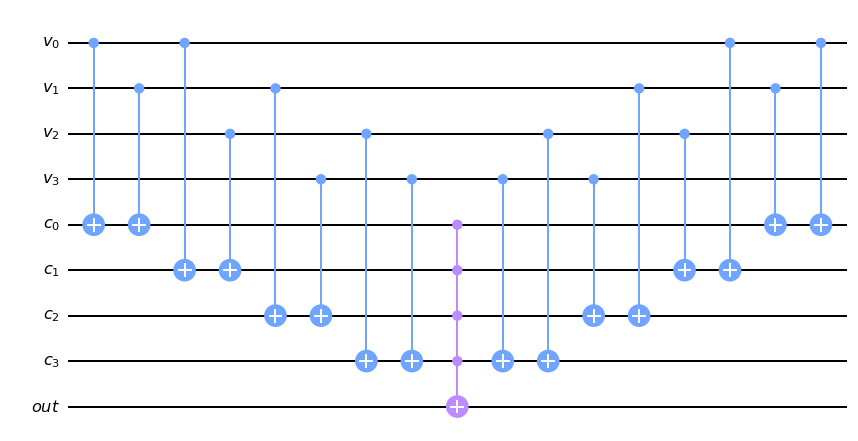

In [225]:
'''
The Sudoku Oracle, using the clause above, from IBM textbook. 
'''
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
# cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)
# qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0

    for clause in reversed(clause_list):
      i -= 1
      XOR(qc, clause[1], clause[0], clause_qubits[i])

sudoku_oracle(qc, clause_list, clause_qubits)

Sudoku_Oracle = qc.to_gate()
Sudoku_Oracle.name = "U$_\omega$"
print("This is the Oracle for 2*2 binary sudoku")
qc.draw('mpl')

In [226]:
from qiskit.circuit.library import *
sim = Aer.get_backend('aer_simulator')
# Simulate the unitary
qc.save_unitary()
qobj = assemble(qc)
unitary = sim.run(qobj).result().get_unitary()
# Display the results:
array_to_latex(unitary, prefix="\\text{Circuit = } ")

<IPython.core.display.Latex object>

In [227]:
print(unitary)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2))
